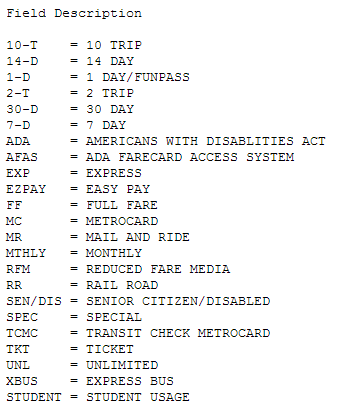

In [198]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [199]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from matplotlib.pylab import plt
#Use package from sklearn.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import operator

%matplotlib inline


In [200]:
mta_fare = np.load("MTA_Fare.npy")

# Event Detection

In [201]:
#23 length dimension represents the ticket types
#600 length dimension represents the stations
#194 length dimension represents the weeks
(mta_fare[0][0])

array([56961, 64703, 68002, 72628, 75866, 72433, 71186, 71498, 73801,
       72517, 74385, 71780, 63174, 66428, 62172, 61027, 56864, 54612,
       55391, 58758, 53615, 55153, 52241, 54237, 56332, 52003, 58227,
       58011, 56841, 54623, 55179, 55156, 61862, 49831, 43851, 44164,
       52134, 53125, 55428, 54826, 56209, 58700, 66411, 62079, 60507,
       64571, 63548, 73987, 69892, 64011, 68611, 66566, 66157, 68076,
       72318, 75898, 85529, 91891, 78091, 76496, 75295, 90936, 89712,
       80988, 78696, 55196, 74775, 69475, 72191, 57003, 68284, 73454,
       73525, 73278, 64865, 69191, 67099, 63017, 67992, 69241, 68079,
       69527, 71535, 66822, 59769, 51868, 54865, 57924, 60498, 58870,
       62098, 60277, 62578, 68971, 71953, 50178, 73127, 76462, 75618,
       71061, 71899, 71825, 67019, 79034, 83422, 76560, 80431, 81958,
       86070, 77442, 86061, 87749, 89065, 85593, 86786, 84939, 82306,
       77443, 74911, 71498, 74978, 71264, 73543, 71579, 70637, 72245,
       11409,     1,

In [202]:
###we want to replace all -1s with NaNs
mta_fare = mta_fare.astype('float')
mta_fare[mta_fare == -1] = np.nan
mta_fare[0][0][120:150]

array([  7.49780000e+04,   7.12640000e+04,   7.35430000e+04,
         7.15790000e+04,   7.06370000e+04,   7.22450000e+04,
         1.14090000e+04,   1.00000000e+00,              nan,
                    nan,   6.00000000e+00,   1.04880000e+04,
         1.55380000e+04,   1.62570000e+04,   2.94040000e+04,
         3.40650000e+04,   2.77650000e+04,   2.81150000e+04,
         2.76340000e+04,   2.59430000e+04,   2.77530000e+04,
         2.98270000e+04,   3.23460000e+04,   3.17100000e+04,
         3.26100000e+04,   3.69590000e+04,   3.57450000e+04,
         3.82650000e+04,   4.60840000e+04,   4.99550000e+04])

In [203]:
#sum for all ride types
mta_allsum = np.nansum(mta_fare, axis=1)
print (mta_allsum.shape)

(600, 194)


In [204]:
mta_allsum_sum = np.nansum(mta_allsum, axis=0)
print (mta_allsum_sum.shape)

(194,)


In [205]:
hi_threshold = np.mean(mta_allsum_sum) + 3 * np.std(mta_allsum_sum)
lo_threshold = np.mean(mta_allsum_sum) - 3 * np.std(mta_allsum_sum)

In [206]:
event = np.where(mta_allsum_sum < lo_threshold)

In [207]:
#generate weekly date range for 194 weeks from 05/21/2010 to 02/21/2014.
weeks = pd.date_range('5/21/2010', periods=194, freq='W-FRI').shift(1, freq=pd.datetools.week)

In [208]:
weeks

DatetimeIndex(['2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
               '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
               '2010-07-23', '2010-07-30',
               ...
               '2013-12-06', '2013-12-13', '2013-12-20', '2013-12-27',
               '2014-01-03', '2014-01-10', '2014-01-17', '2014-01-24',
               '2014-01-31', '2014-02-07'],
              dtype='datetime64[ns]', length=194, freq='W-FRI')

In [209]:
weeks[126]

Timestamp('2012-10-26 00:00:00', offset='W-FRI')

In [210]:
weeks[event]

DatetimeIndex(['2012-10-26'], dtype='datetime64[ns]', freq=None)

## Event Detection Conclusion:
Ah ha! We can see that on the 127th week (which falls at the end of October 2012) there was an event where ridership across all stations and rider-types fell below a three-standard deviation threshold. Checking our NYC calendars, we can see that this coincides with Hurricane Sandy, one of the most damaging storms to ever occur in NYC's history. So it's obvious why ridership fell that week!

# Time-series Trend Analysis
### Identify the ridership types that have steadily increased in popularity, and that have steadily decreased. By how much?

In [211]:
#sum for all stations (by ridetype)
mta_by_ridetype = np.nansum(mta_fare, axis=0)
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [212]:
#create array that is the percent to total (by week) across ridertypes
mta_by_ridetype_pct = np.zeros((len(mta_by_ridetype),len(mta_by_ridetype[0])))
for i in range(len(mta_allsum_sum)):
    for j in range(len(ridetype)):
        mta_by_ridetype_pct[j][i] = mta_by_ridetype[j][i] / mta_allsum_sum[i]

In [213]:
#generate weekly date range for same number of weeks as mta data.
weeks2 = pd.date_range('5/21/2010', periods=len(mta_by_ridetype_pct[0]), freq='W-FRI')

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


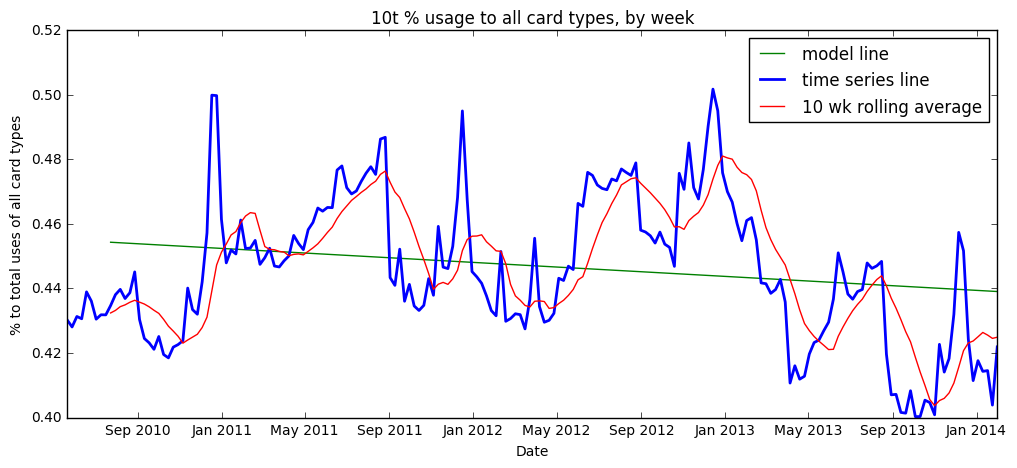

('Cardtype: ', '10t')
('Ratio = ', 0.98236736269867631)
('fitted model coefficient = ', -8.2929439699473329e-05)
('fitted model coefficient 95% confidence interval: ', -0.00013163416022224681, -3.4224719176699858e-05)
('R-squared of fitted model = ', 0.058088955389206887)


10t exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


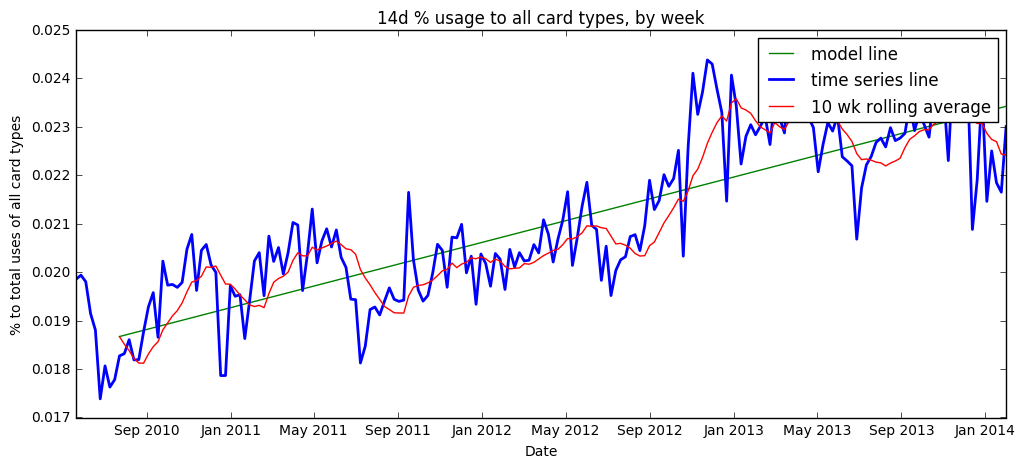

('Cardtype: ', '14d')
('Ratio = ', 1.1990930610525672)
('fitted model coefficient = ', 2.5831874803418958e-05)
('fitted model coefficient 95% confidence interval: ', 2.4074130569093928e-05, 2.7589619037743988e-05)
('R-squared of fitted model = ', 0.82124306528672353)


14d exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


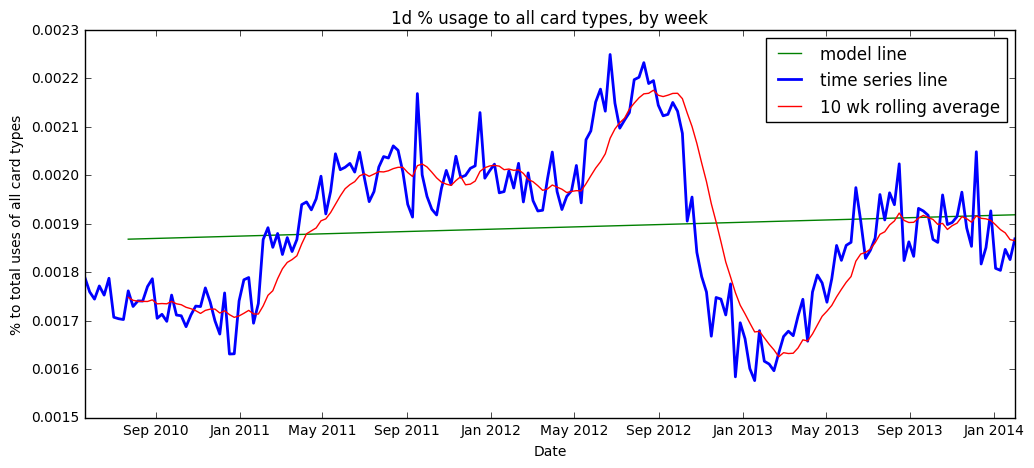

('Cardtype: ', '1d')
('Ratio = ', 1.0692019864027336)
('fitted model coefficient = ', 2.7358478865462904e-07)
('fitted model coefficient 95% confidence interval: ', -1.1628197443011782e-07, 6.634515517393759e-07)
('R-squared of fitted model = ', 0.010366547990089403)


1d exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


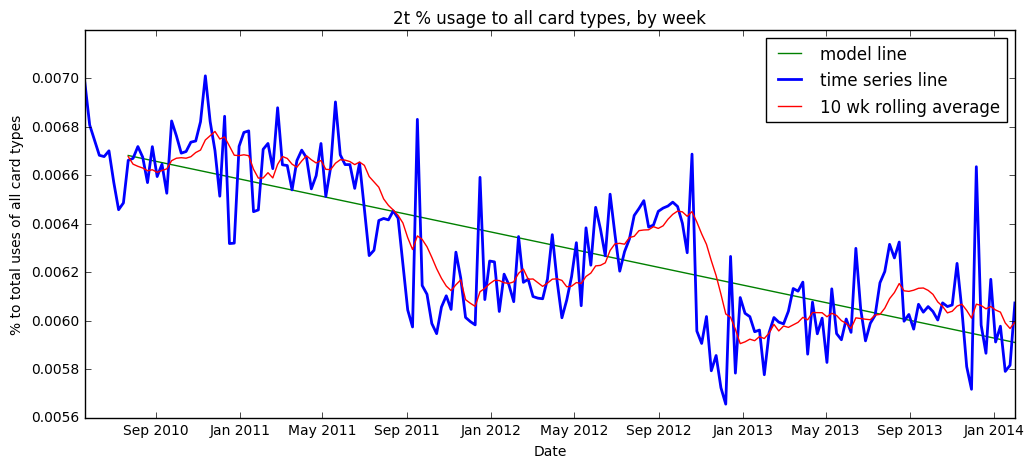

('Cardtype: ', '2t')
('Ratio = ', 0.89347957853140958)
('fitted model coefficient = ', -4.1958265038552219e-06)
('fitted model coefficient 95% confidence interval: ', -4.5738208388038831e-06, -3.8178321689065606e-06)
('R-squared of fitted model = ', 0.72383584973784088)


2t exhibits a decreasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is negative and does not include zero.


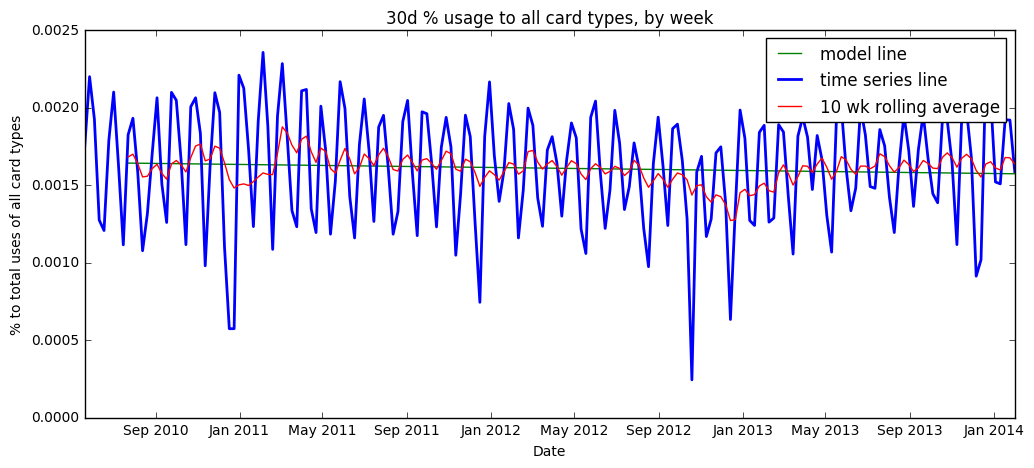

('Cardtype: ', '30d')
('Ratio = ', 1.0062442281944524)
('fitted model coefficient = ', -3.7431792642978629e-07)
('fitted model coefficient 95% confidence interval: ', -6.1392788395731917e-07, -1.3470796890225347e-07)
('R-squared of fitted model = ', 0.049351442171269522)


30d exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


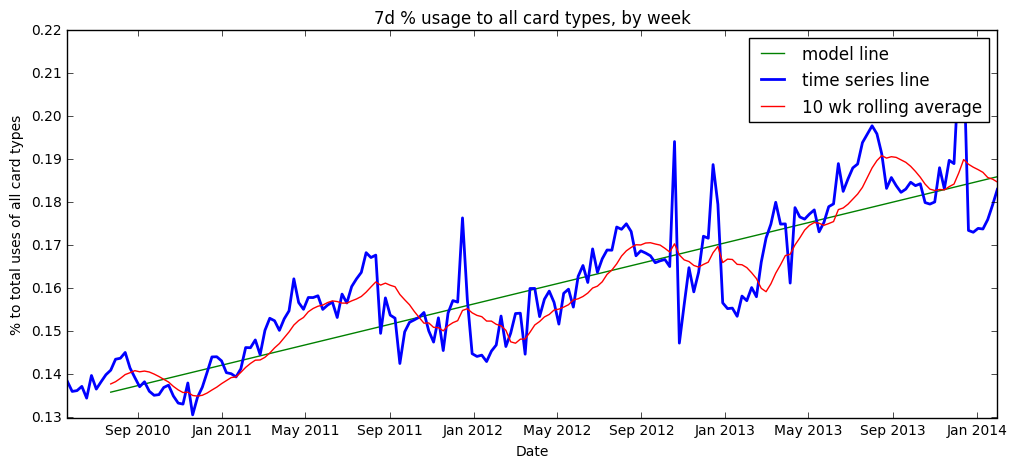

('Cardtype: ', '7d')
('Ratio = ', 1.3486406310272443)
('fitted model coefficient = ', 0.00027195379218318864)
('fitted model coefficient 95% confidence interval: ', 0.00025666246402296898, 0.0002872451203434083)
('R-squared of fitted model = ', 0.87060616339008301)


7d exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


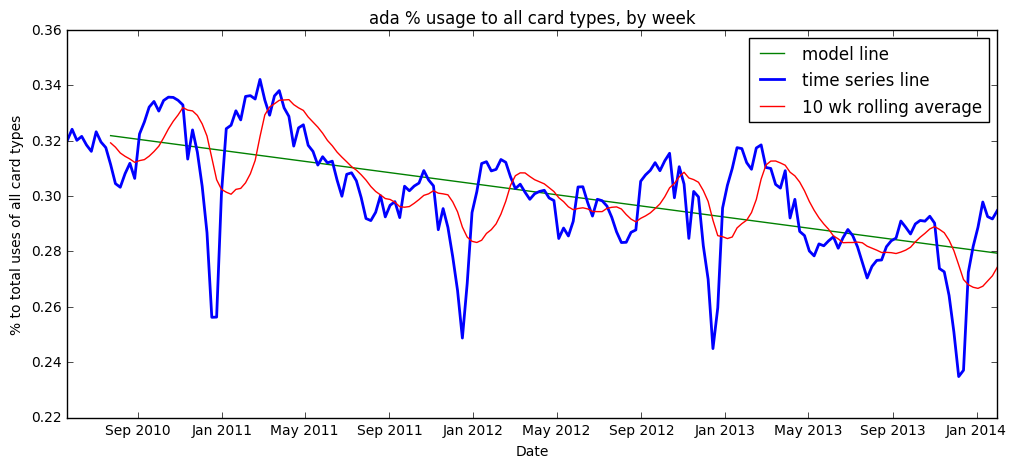

('Cardtype: ', 'ada')
('Ratio = ', 0.84728043315602841)
('fitted model coefficient = ', -0.00023075966772493297)
('fitted model coefficient 95% confidence interval: ', -0.00025796842425871439, -0.00020355091119115152)
('R-squared of fitted model = ', 0.60475371428175539)


ada exhibits a decreasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is negative and does not include zero.


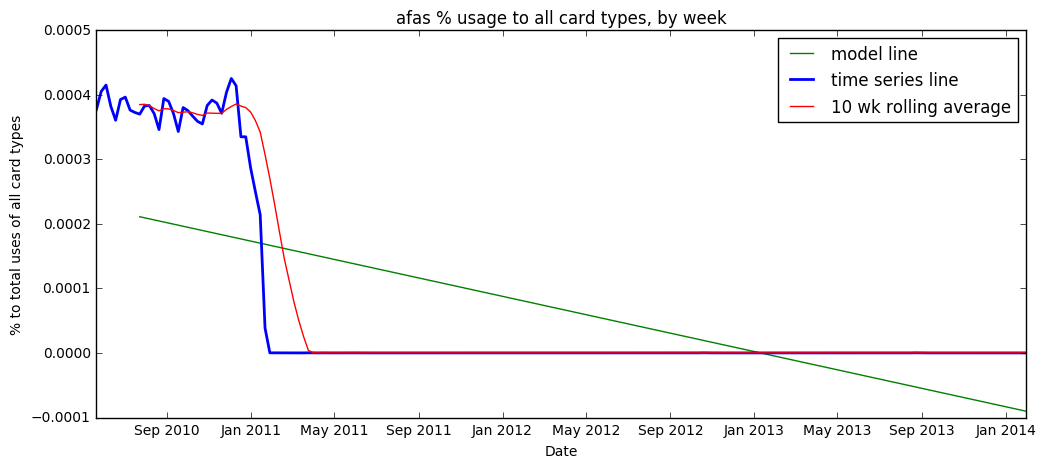

('Cardtype: ', 'afas')
('Ratio = ', 0.00020186073574338223)
('fitted model coefficient = ', -1.6370646118722354e-06)
('fitted model coefficient 95% confidence interval: ', -1.9105973981231121e-06, -1.3635318256213585e-06)
('R-squared of fitted model = ', 0.43244401817798661)


afas exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


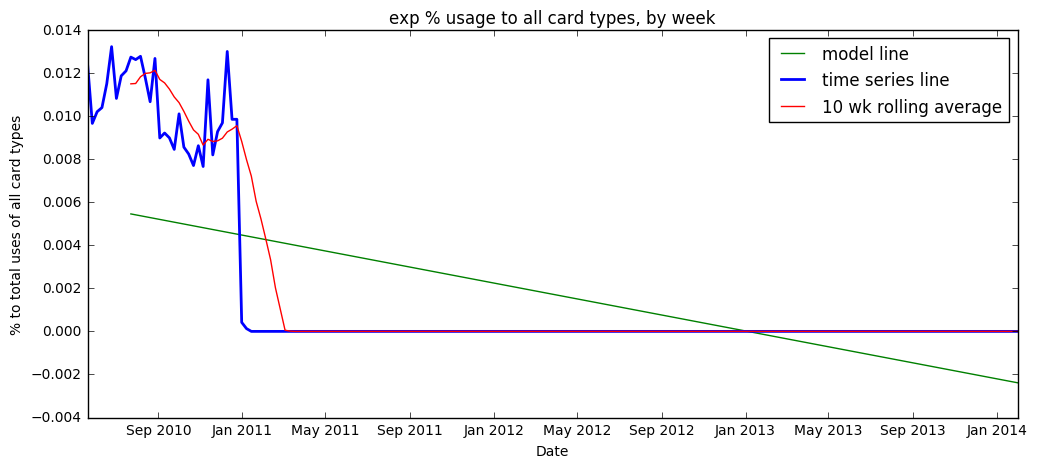

('Cardtype: ', 'exp')
('Ratio = ', 1.0689313461717185e-05)
('fitted model coefficient = ', -4.2622855018242608e-05)
('fitted model coefficient 95% confidence interval: ', -5.0118114251295792e-05, -3.5127595785189424e-05)
('R-squared of fitted model = ', 0.40754493520471091)


exp exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


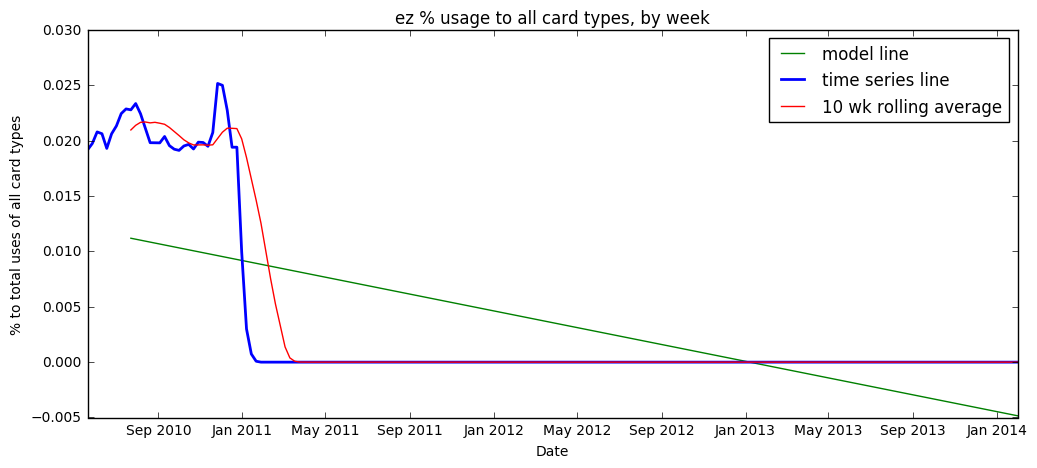

('Cardtype: ', 'ez')
('Ratio = ', 1.623611606089334e-06)
('fitted model coefficient = ', -8.7141507369414939e-05)
('fitted model coefficient 95% confidence interval: ', -0.00010219492996936561, -7.2088084769464267e-05)
('R-squared of fitted model = ', 0.41617200930172771)


ez exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


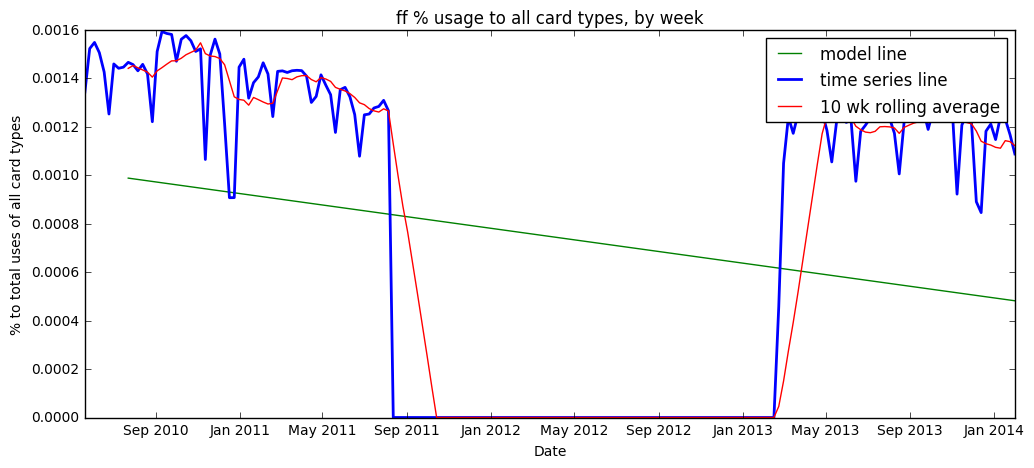

('Cardtype: ', 'ff')
('Ratio = ', 0.79162326893697699)
('fitted model coefficient = ', -2.7523444094278714e-06)
('fitted model coefficient 95% confidence interval: ', -4.4258118662997511e-06, -1.0788769525559918e-06)
('R-squared of fitted model = ', 0.054410412707084355)


ff exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


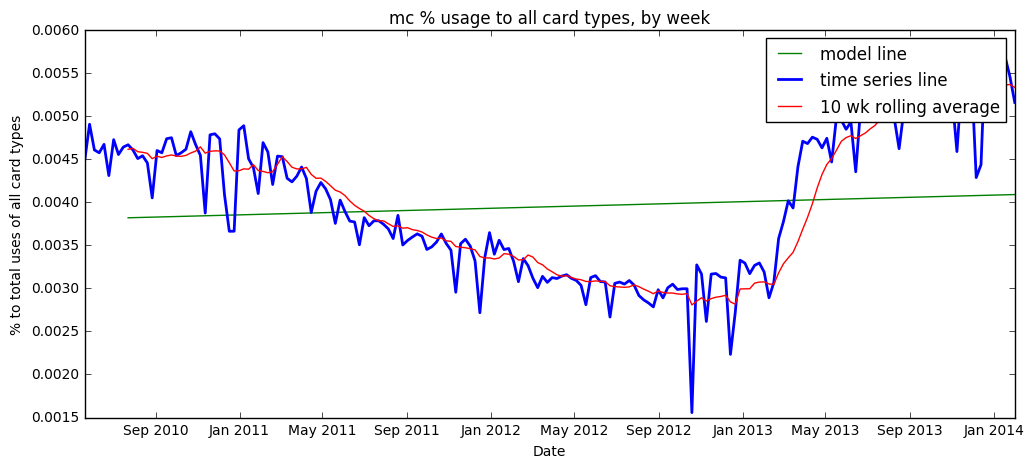

('Cardtype: ', 'mc')
('Ratio = ', 1.1645765270437543)
('fitted model coefficient = ', 1.4659070837912751e-06)
('fitted model coefficient 95% confidence interval: ', -6.3512312786719339e-07, 3.5669372954497435e-06)
('R-squared of fitted model = ', 0.010249025100477427)


mc exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


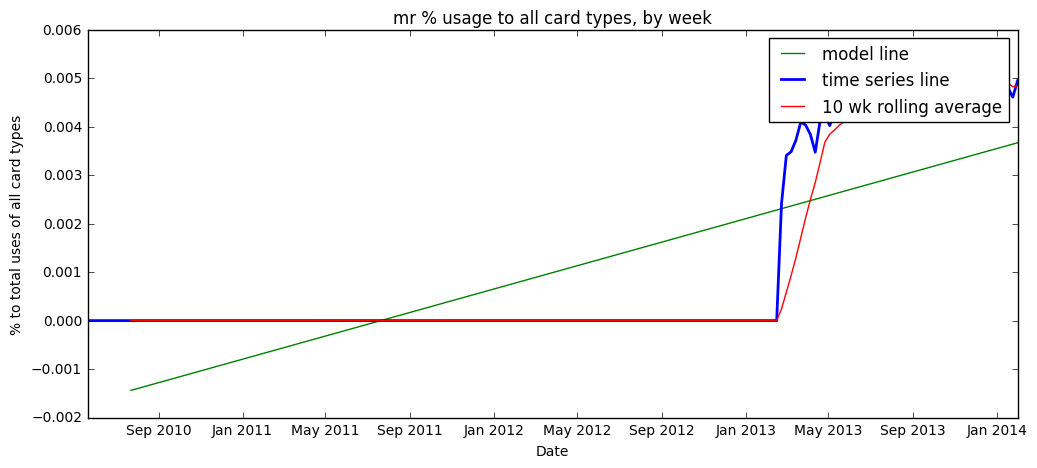

('Cardtype: ', 'mr')
('Ratio = ', 24080.948554518323)
('fitted model coefficient = ', 2.778234397802825e-05)
('fitted model coefficient 95% confidence interval: ', 2.4347008385056618e-05, 3.1217679570999885e-05)
('R-squared of fitted model = ', 0.58181012228458617)


mr exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


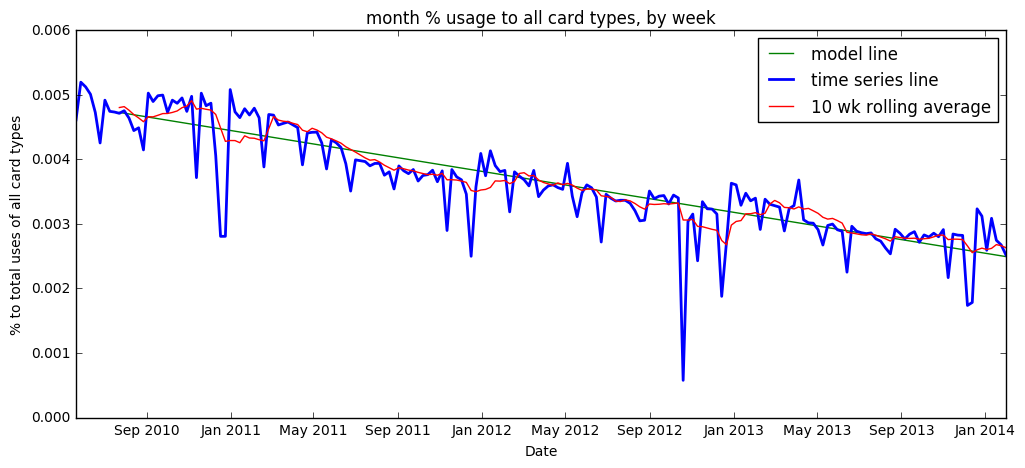

('Cardtype: ', 'month')
('Ratio = ', 0.55308696678002911)
('fitted model coefficient = ', -1.2135764931809136e-05)
('fitted model coefficient 95% confidence interval: ', -1.258491913403578e-05, -1.1686610729582491e-05)
('R-squared of fitted model = ', 0.93950134715032241)


month exhibits a decreasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is negative and does not include zero.


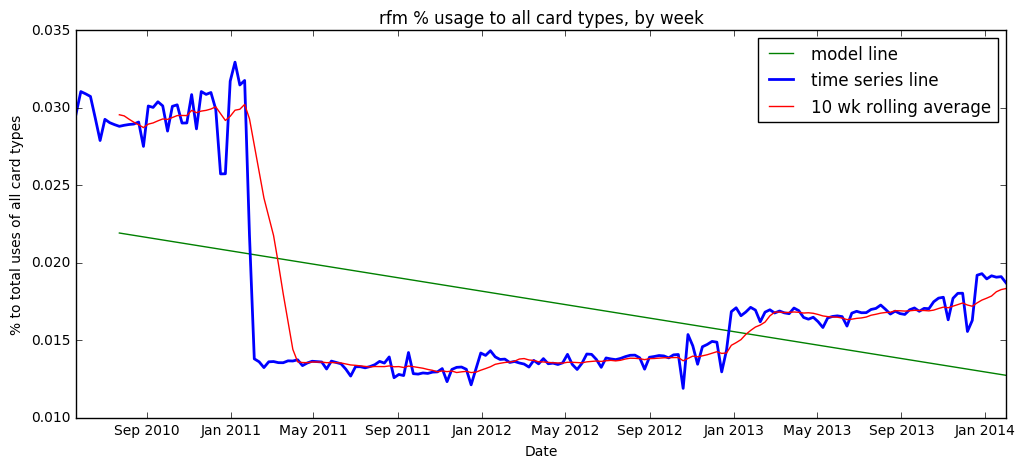

('Cardtype: ', 'rfm')
('Ratio = ', 0.6163348685459592)
('fitted model coefficient = ', -4.9888343164667304e-05)
('fitted model coefficient 95% confidence interval: ', -6.3297004167265004e-05, -3.6479682162069603e-05)
('R-squared of fitted model = ', 0.227480881332222)


rfm exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


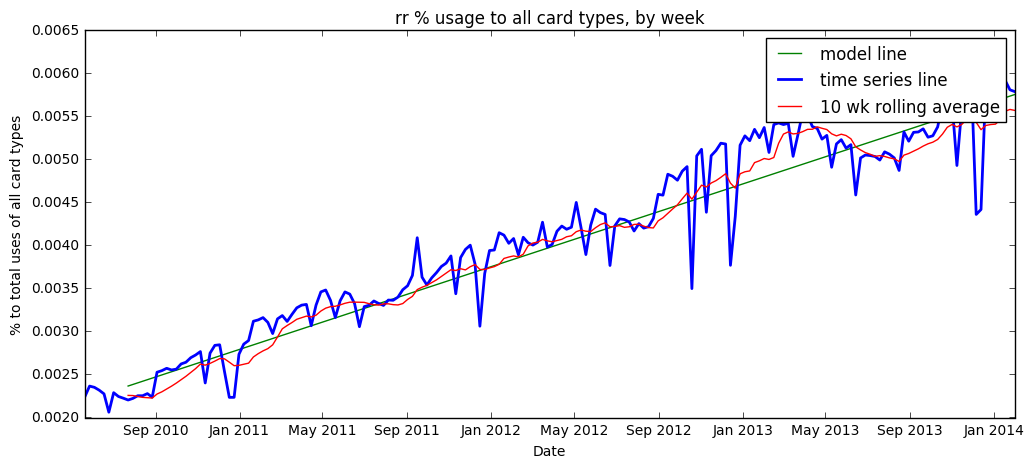

('Cardtype: ', 'rr')
('Ratio = ', 2.4651804745390677)
('fitted model coefficient = ', 1.8397248047083114e-05)
('fitted model coefficient 95% confidence interval: ', 1.7955937213206937e-05, 1.8838558880959291e-05)
('R-squared of fitted model = ', 0.97366196742103484)


rr exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


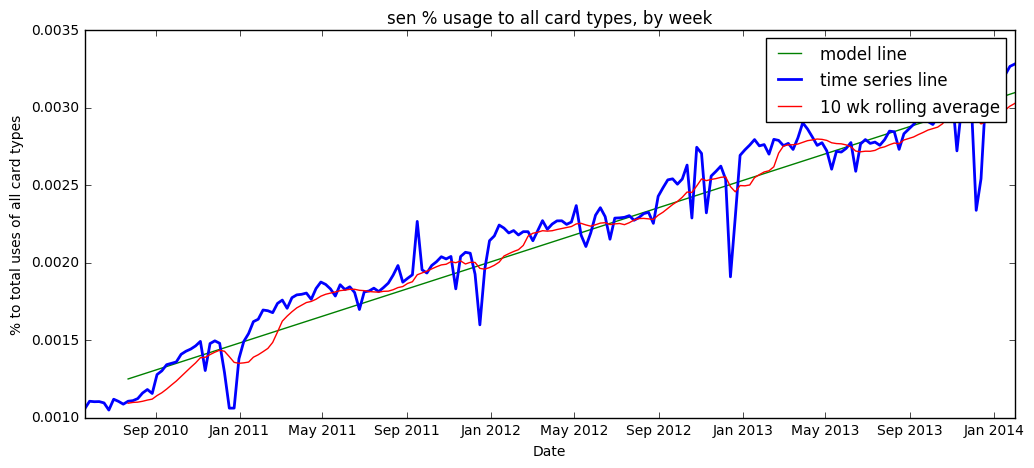

('Cardtype: ', 'sen')
('Ratio = ', 2.7586333319301786)
('fitted model coefficient = ', 1.0037486551289493e-05)
('fitted model coefficient 95% confidence interval: ', 9.814058356791553e-06, 1.0260914745787433e-05)
('R-squared of fitted model = ', 0.97723761072388882)


sen exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


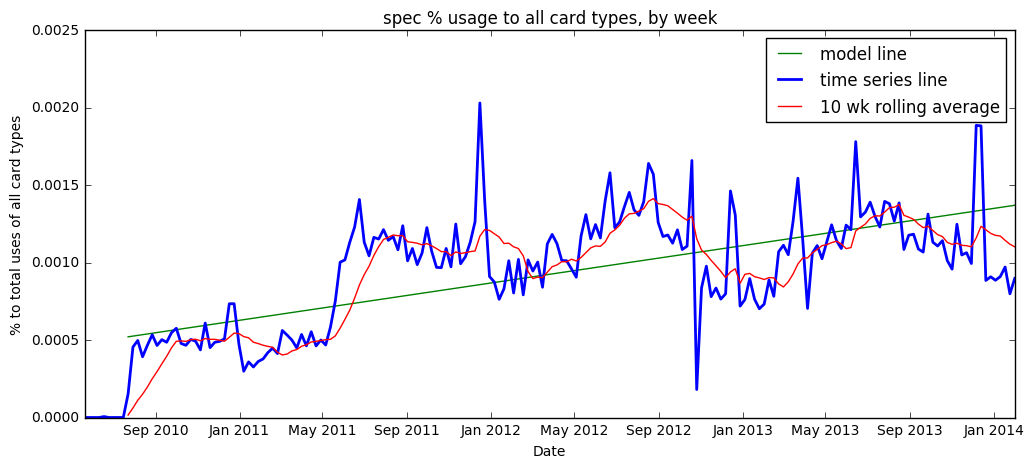

('Cardtype: ', 'spec')
('Ratio = ', 1611.9627821618897)
('fitted model coefficient = ', 4.6120554794708709e-06)
('fitted model coefficient 95% confidence interval: ', 4.0282068093304727e-06, 5.1959041496112692e-06)
('R-squared of fitted model = ', 0.57033315793993955)


spec exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


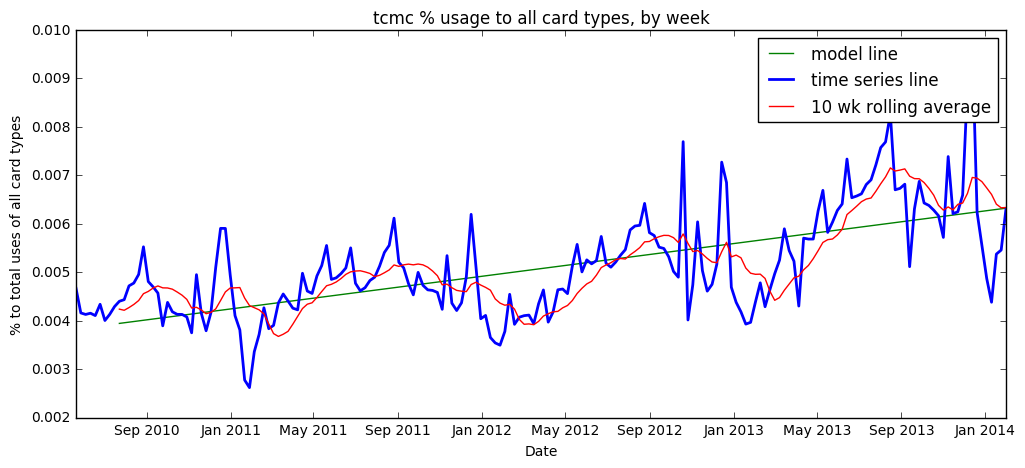

('Cardtype: ', 'tcmc')
('Ratio = ', 1.5001537758518757)
('fitted model coefficient = ', 1.2927517943030462e-05)
('fitted model coefficient 95% confidence interval: ', 1.1478034692476923e-05, 1.4377001193584001e-05)
('R-squared of fitted model = ', 0.62853535264241356)


tcmc exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


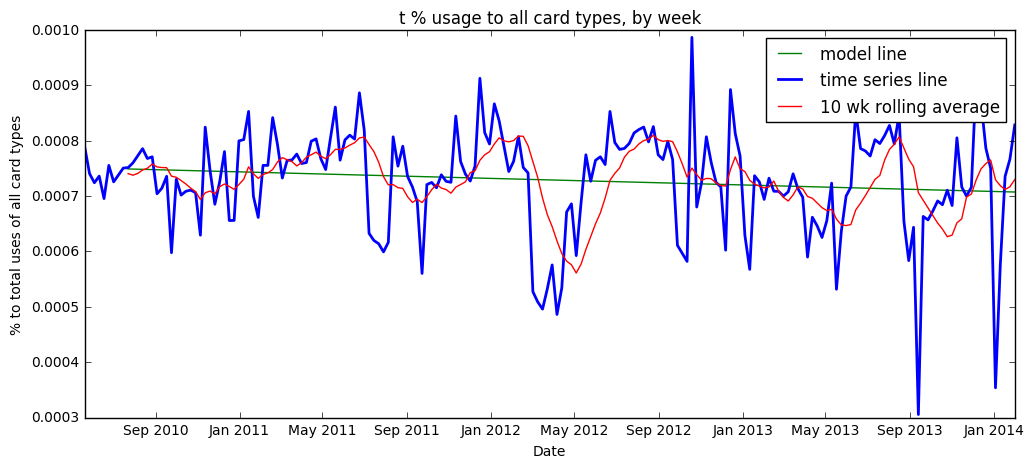

('Cardtype: ', 't')
('Ratio = ', 0.96964036520126629)
('fitted model coefficient = ', -2.2633587214333609e-07)
('fitted model coefficient 95% confidence interval: ', -3.6140372061552284e-07, -9.1268023671149333e-08)
('R-squared of fitted model = ', 0.056365694889957019)


t exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


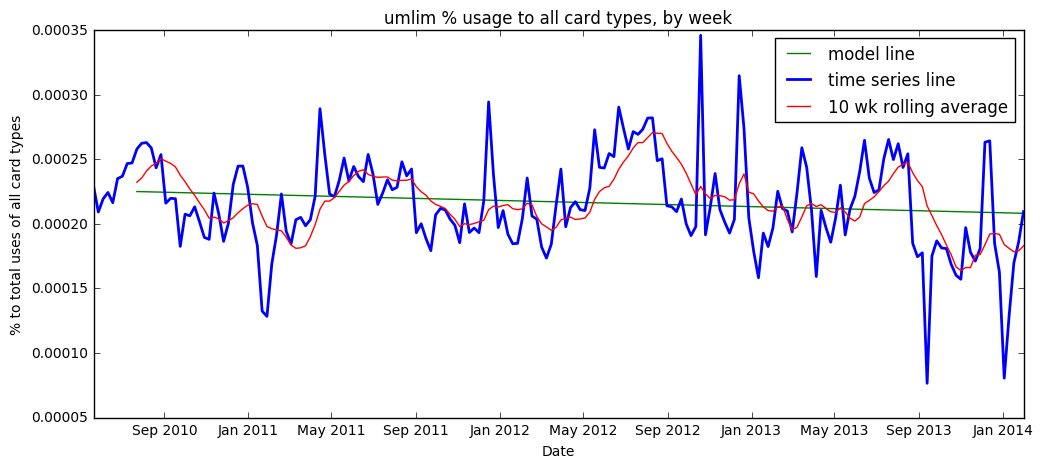

('Cardtype: ', 'umlim')
('Ratio = ', 0.78100935334091859)
('fitted model coefficient = ', -9.1478053288952903e-08)
('fitted model coefficient 95% confidence interval: ', -1.499422470244045e-07, -3.3013859553501294e-08)
('R-squared of fitted model = ', 0.049500990940399059)


umlim exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


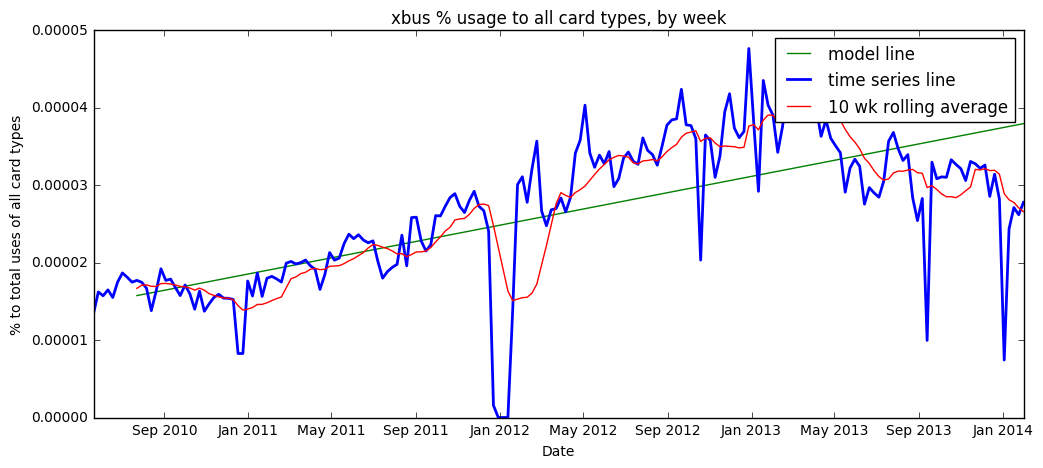

('Cardtype: ', 'xbus')
('Ratio = ', 1.6350298164596213)
('fitted model coefficient = ', 1.205955975883246e-07)
('fitted model coefficient 95% confidence interval: ', 1.074883020233626e-07, 1.337028931532866e-07)
('R-squared of fitted model = ', 0.64294835363622038)


xbus exhibits an increasing trend in popularity from May 2010 to Feb 2014.
This is due to the fitted model r-squared being above .6 
(meaning it is not a changing structure, it is an actual trend)
and the fact that the 95% confidence interval for the 
coefficient of the fitted model line is positive and does not include zero.


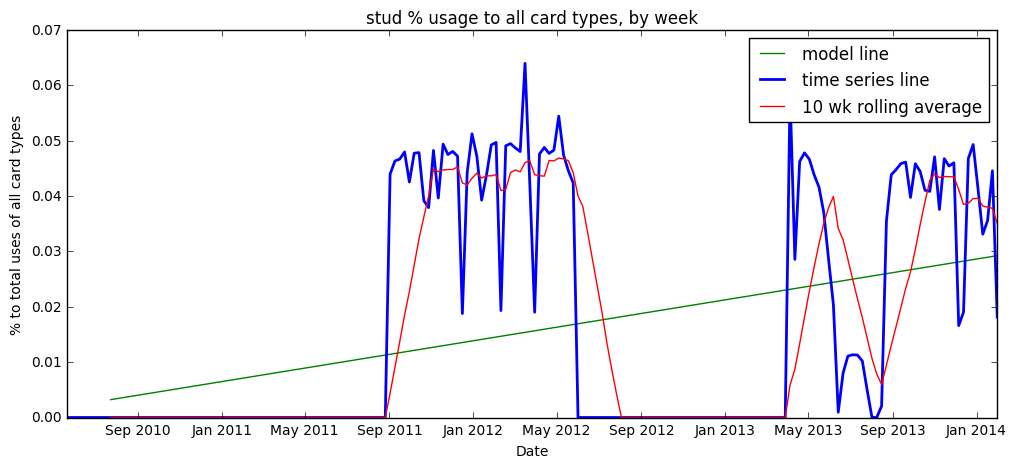

('Cardtype: ', 'stud')
('Ratio = ', inf)
('fitted model coefficient = ', 0.00014135253883001752)
('fitted model coefficient 95% confidence interval: ', 9.4545916774449768e-05, 0.00018815916088558526)
('R-squared of fitted model = ', 0.16247881842344125)


stud exhibits either a stationary trend in popularity 
from May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.


In [214]:
#for each ridetype, plot time series
increase_trend = []
decrease_trend = []
stationary_trend = []
for i in range(len(ridetype)):
    #fit linear regression to time series models
    df = pd.DataFrame(weeks2, columns=['weeks2'])
    df['week_number'] = df.index
    df['mta_ridetype_pct'] = mta_by_ridetype_pct[i]
    df['mta_ridetype_pct_rolling_mean'] = pd.rolling_mean(df.mta_ridetype_pct, 10)
    df = df.dropna()
    results = smf.ols(formula = 'mta_ridetype_pct_rolling_mean ~ week_number', data=df).fit()
    plt.figure(figsize=(12,5))
    plt.plot(df.weeks2, results.predict(), c='g', label='model line')
    plt.plot(weeks2, mta_by_ridetype_pct[i], linewidth=2.0, label='time series line')
    plt.plot(df.weeks2, df.mta_ridetype_pct_rolling_mean, c='r', label='10 wk rolling average')
    plt.xlabel('Date')
    plt.ylabel('% to total uses of all card types')
    plt.title(ridetype[i] + ' % usage to all card types, by week')
    plt.legend()
    results.conf_int(alpha=0.05)[1:]
    plt.show()
    rider_change = mta_by_ridetype_pct[i][len(mta_by_ridetype_pct[0])-11:len(mta_by_ridetype_pct[0])-1].mean() / mta_by_ridetype_pct[i][0:9].mean() 
    '''
    print("Cardtype: %s\nRatio = %.2f\nfitted model coefficient= %.6f\nfitted model coefficient 95% confidence interval= %.2f, %.2f\nR-squared of fitted model = %.2f" \
          % (ridetype[i], rider_change, results.params[1], results.conf_int(alpha=0.05)[1:][0][0], results.conf_int(alpha=0.05)[1:][1][0], results.rsquared))
    '''
    print('Cardtype: ', ridetype[i])
    print('Ratio = ', rider_change)
    print('fitted model coefficient = ', results.params[1])
    print('fitted model coefficient 95% confidence interval: ', results.conf_int(alpha=0.05)[1:][0][0], results.conf_int(alpha=0.05)[1:][1][0])
    print('R-squared of fitted model = ', results.rsquared)
    print('\n')
    #if the resulting fitted model has an r-squared above .6 and a 95% confidence interval positive and not including zero then increasing!
    if (results.conf_int(alpha=0.05)[1:][0][0] > 0) and (results.rsquared > 0.6):
        print(ridetype[i] + ' exhibits an increasing trend in popularity from May 2010 to Feb 2014.')
        print('This is due to the fitted model r-squared being above .6 \n(meaning it is not a changing structure, it is an actual trend)')
        print('and the fact that the 95% confidence interval for the \ncoefficient of the fitted model line is positive and does not include zero.')
        increase_trend.append(ridetype[i])
    elif (results.conf_int(alpha=0.05)[1:][1][0] < 0) and (results.rsquared > 0.6):
    #if the resulting fitted model has an r-squared above .6 and a 95% confidence interval negative and not including zero then decreasing!    
        print(ridetype[i] + ' exhibits a decreasing trend in popularity from May 2010 to Feb 2014.')
        print('This is due to the fitted model r-squared being above .6 \n(meaning it is not a changing structure, it is an actual trend)')
        print('and the fact that the 95% confidence interval for the \ncoefficient of the fitted model line is negative and does not include zero.')        
        decrease_trend.append(ridetype[i])
    else:
        print(ridetype[i] + ' exhibits either a stationary trend in popularity \nfrom May 2010 to Feb 2014, or exhibits a changing structure, rather than trend.')
        stationary_trend.append(ridetype[i])        

## Ride Type Ratio

### Increasing trend:
If ratio is very high, then there has been a large increase in the card type's usage over. We can see this in the following: ['14d', '7d', 'rr', 'sen', 'tcmc', 'xbus']

In [215]:
increase_trend

['14d', '7d', 'rr', 'sen', 'tcmc', 'xbus']

The steepest trend increase is 'sen' with a ratio of 2.75.

### Decreasing trend:
If ratio is very low, then it exhibits a decreasing trend. We can see this in the following: ['2t', 'ada', 'month']

In [216]:
decrease_trend

['2t', 'ada', 'month']

The steepest trend decrease is 'month' with a ratio of 0.55.

### Stationary trend / change in structure:
If ratio is close to one, then the time series is stationary. If the R-squared is less than .6, then there is a structural change in usage, rather than a trend. We can see this happening in the following: ['10t',
 '1d',
 '30d',
 'afas',
 'exp',
 'ez',
 'ff',
 'mc',
 'mr',
 'rfm',
 'spec',
 't',
 'umlim',
 'stud']

In [217]:
stationary_trend

['10t',
 '1d',
 '30d',
 'afas',
 'exp',
 'ez',
 'ff',
 'mc',
 'mr',
 'rfm',
 'spec',
 't',
 'umlim',
 'stud']

# Finding 52-week Periocity by Subway Station

### 52 week period should happen 4 times over the course of the 194 weeks we look at. Therefore, the frequency is 4. We want to look at the fourth element of the real fourier transformation array, as that will return the "power" for frequencies of 4. The stations with higher "power" at these frequencies will have higher 52-week periocity.

In [273]:
station_dict = {}
for i in range(len(mta_allsum)):
    dict_key = str(i)
    station_dict[dict_key] = np.abs(np.fft.rfft(mta_allsum[i]))[4]
    
sorted_station_dict = sorted(station_dict.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_station_dict)

[('0', 2980160.6355953491), ('194', 2950388.929214194), ('150', 2931895.8769513383), ('327', 2402218.5809588572), ('32', 2329896.5813884307), ('539', 1351574.8989024682), ('19', 1324540.8730565044), ('169', 1221609.9059111718), ('56', 1078273.1517900799), ('54', 1039248.4697460521), ('163', 962402.7715005714), ('226', 856387.3428242174), ('83', 855289.83547739626), ('126', 854001.11773597205), ('45', 838336.2878440012), ('13', 828729.47357682534), ('86', 822951.90281376219), ('17', 787646.64675592002), ('549', 744079.64771315688), ('462', 742574.14822174632), ('27', 739719.50967775984), ('461', 692893.19401050708), ('176', 688689.36332722788), ('28', 672420.22450754838), ('548', 666155.14198864426), ('105', 662848.69043516205), ('171', 639960.56944394473), ('43', 638993.32694614027), ('540', 627894.26700473134), ('311', 551122.7557577925), ('535', 546957.09654815879), ('26', 534393.00314374547), ('20', 523471.24011364859), ('1', 517792.73741749104), ('87', 512062.64832833118), ('221', 

### We can see above in the sorted dictionary that stations 0, 194, 150, & 327 have the highest power measurements for frequency = 4.

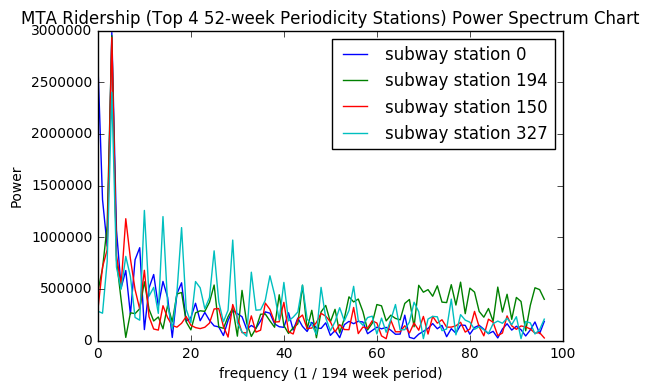

In [277]:
subway_list_1 = [0, 194, 150, 327]
for i in range(len(subway_list_1)):
    name = 'subway station '+str(subway_list[i])
    n = (np.abs(np.fft.rfft(mta_allsum[subway_list[i]])))
    plt.plot(n[1:], label=name)
    plt.ylabel('Power')
    plt.xlabel('frequency (1 / 194 week period)')
    plt.title('MTA Ridership (Top 4 52-week Periodicity Stations) Power Spectrum Chart')
    plt.legend()

### The plot above shows the power spectrum chart for the top 4 subway stations in terms of highest 52-week periodicity - we can see a great peak at around a frequency of 4.

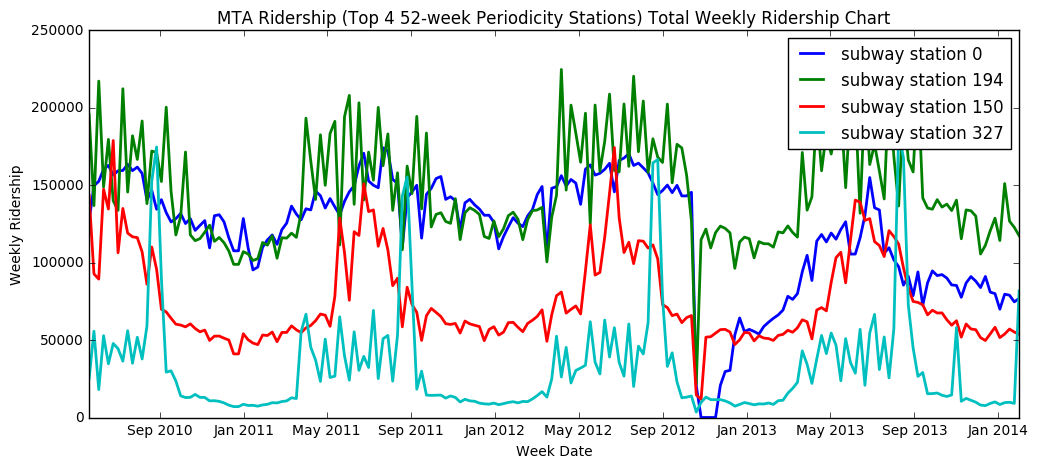

In [276]:
plt.figure(figsize=(12,5))
for i in range(len(subway_list)):
    name = 'subway station '+str(subway_list[i])
    plt.plot(weeks2, mta_allsum[subway_list_1[i]], linewidth=2.0, label=name)
    plt.ylabel('Weekly Ridership')
    plt.xlabel('Week Date')
    plt.title('MTA Ridership (Top 4 52-week Periodicity Stations) Total Weekly Ridership Chart')
    plt.legend()

### The plot above shows the time series for the top 4 subway stations in terms of highest 52-week periodicity. We can see that for all of them, they peak during the summer months and tail off during the winter months. These seasonal trends absolutely follow a 52-week period. Subway station 327 even has a sharp peak once a year on the same week. My guess is that it is the Mets - Willets Point Station, with the peak coming at the end of August, exactly coinciding with the popular U.S. Open Tennis tournament!